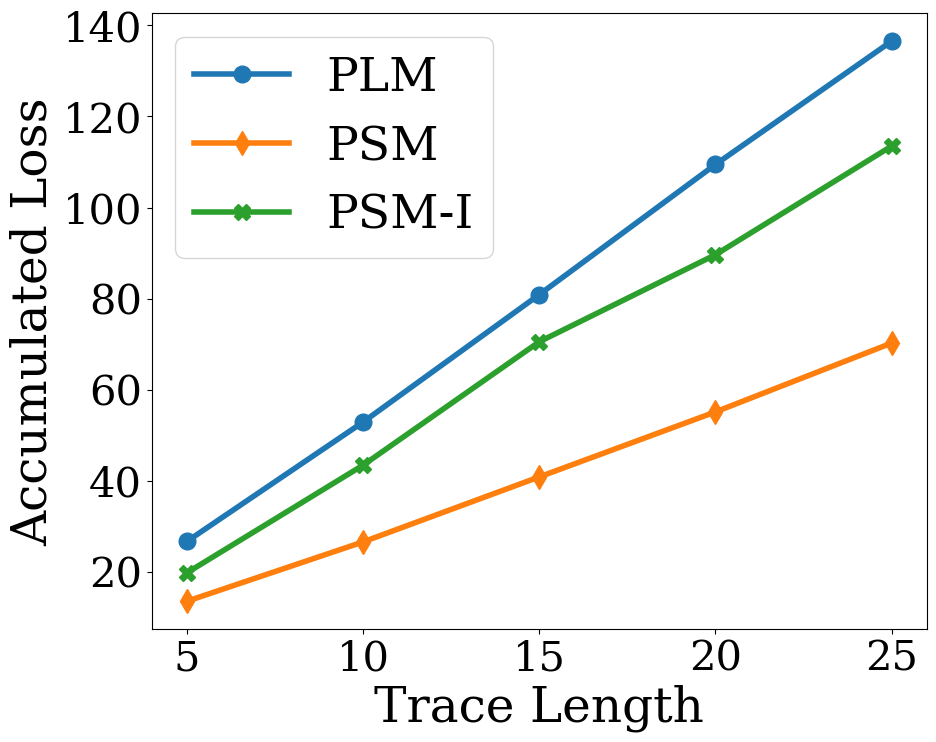

In [4]:
# ============================================================
# Trace length vs. accumulated loss (DROP-IN notebook version)
# - Uses your NEW PLM / NEW PSM / NEW PSM-I (no TR-PSM)
# - Removes unused imports + old samplers
# ============================================================

import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from noise_distribution import (
    sample_laplace_radius,
    sample_psm_radius,
    sample_psm_radius_bounded
)
from util import haversine_distance, initial_bearing, destination_point

# =============================================================================
# 1) MATPLOTLIB STYLING (same vibe, but simple)
# =============================================================================
mpl.rcParams['text.usetex']      = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family']      = 'serif'
mpl.rcParams['font.size']        = 30

# =============================================================================
# 2) CONSTANTS
# =============================================================================
EARTH_RADIUS        = 6_371_000  # meters
OVERLAY_RADIUS      = 100        # meters
POKEMON_MAX_RADIUS  = 1000       # meters
POKEMON_SPACING     = 25         # meters
DELTA_THRESHOLD     = 5.0        # base refresh threshold (PSM-I)
FIXED_CENTER        = (43.083789, -77.680391)

# =============================================================================
# 3) TRAJECTORY GENERATOR (synthetic)
# =============================================================================
def move_point(lat, lon, dist_m, bearing_deg, earth_radius=EARTH_RADIUS):
    φ1 = math.radians(lat)
    λ1 = math.radians(lon)
    θ  = math.radians(bearing_deg)
    δ  = dist_m / earth_radius
    φ2 = math.asin(math.sin(φ1)*math.cos(δ) +
                   math.cos(φ1)*math.sin(δ)*math.cos(θ))
    λ2 = λ1 + math.atan2(math.sin(θ)*math.sin(δ)*math.cos(φ1),
                         math.cos(δ)-math.sin(φ1)*math.sin(φ2))
    return math.degrees(φ2), math.degrees(λ2)

def generate_trajectory(start_lat, start_lon, step_distance_m, m):
    traj = [(start_lat, start_lon)]
    lat, lon = start_lat, start_lon
    for _ in range(m - 1):
        bearing = random.uniform(0, 360)
        lat, lon = move_point(lat, lon, step_distance_m, bearing)
        traj.append((lat, lon))
    return traj

# =============================================================================
# 4) POKÉMON POSITIONS
# =============================================================================
def generate_uniform_pokemon_positions(center, max_radius, spacing):
    lat0, lon0 = center
    deg_lat = 1/111320.0
    deg_lon = 1/(111320.0 * math.cos(math.radians(lat0)))
    positions = []

    lat = lat0 - max_radius * deg_lat
    while lat <= lat0 + max_radius * deg_lat:
        lon = lon0 - max_radius * deg_lon
        while lon <= lon0 + max_radius * deg_lon:
            if haversine_distance(lat0, lon0, lat, lon, EARTH_RADIUS) <= max_radius:
                positions.append((lat, lon))
            lon += spacing * deg_lon
        lat += spacing * deg_lat
    return positions

POKEMONS = generate_uniform_pokemon_positions(FIXED_CENTER, POKEMON_MAX_RADIUS, POKEMON_SPACING)

# =============================================================================
# 5) METRIC: catch% + accumulated loss
# =============================================================================
def compute_catch_and_loss(true_locs, pert_locs, overlay_radius=OVERLAY_RADIUS):
    total_true = total_intersect = acc_loss = 0
    for (lat_t, lon_t), (lat_p, lon_p) in zip(true_locs, pert_locs):
        V = [p for p in POKEMONS
             if haversine_distance(lat_t, lon_t, p[0], p[1], EARTH_RADIUS) <= overlay_radius]
        Vhat = [p for p in V
                if haversine_distance(lat_p, lon_p, p[0], p[1], EARTH_RADIUS) <= overlay_radius]
        total_true      += len(V)
        total_intersect += len(Vhat)
        acc_loss        += (len(V) - len(Vhat))

    catch_pct = (total_intersect/total_true)*100 if total_true else 0.0
    return catch_pct, acc_loss

# =============================================================================
# 6) NEW MECHANISMS (PLM / PSM / PSM-I)
# =============================================================================
def planar_laplace_mechanism(lat: float, lon: float, epsilon: float, earth_radius: float = EARTH_RADIUS):
    r = sample_laplace_radius(epsilon)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p

def planar_staircase_mechanism(lat: float, lon: float, epsilon: float, delta: float = 1.0, earth_radius: float = EARTH_RADIUS):
    r = sample_psm_radius(epsilon, delta=delta)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p

def bounded_planar_staircase_mechanism(lat, lon, epsilon, r_b, earth_radius: float = EARTH_RADIUS, delta_step: float = 1.0):
    r = sample_psm_radius_bounded(epsilon, L=r_b, delta=delta_step)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p

def apply_psmi_to_dataframe(
    df,
    epsilon,
    delta,
    r_b=50.0,
    thr_L=2.0,                    # bound for threshold-noise (your “good results”)
    earth_radius: float = EARTH_RADIUS,
    use_noisy_threshold=True
):
    n = len(df)
    y_lat = np.zeros(n)
    y_lon = np.zeros(n)
    z_lat = np.zeros(n)
    z_lon = np.zeros(n)

    # threshold sampled once per trajectory
    threshold = float(delta)
    if use_noisy_threshold:
        noise = sample_psm_radius_bounded(epsilon, L=thr_L, delta=delta)
        threshold = float(delta + noise)

    # init
    x1_lat, x1_lon = float(df.iloc[0]["latitude"]), float(df.iloc[0]["longitude"])
    y1_lat, y1_lon = bounded_planar_staircase_mechanism(
        x1_lat, x1_lon, epsilon, r_b,
        earth_radius=earth_radius,
        delta_step=delta
    )
    z1_lat, z1_lon = planar_staircase_mechanism(
        y1_lat, y1_lon, epsilon,
        delta=delta,
        earth_radius=earth_radius
    )

    y_lat[0], y_lon[0] = y1_lat, y1_lon
    z_lat[0], z_lon[0] = z1_lat, z1_lon

    y_ref_lat, y_ref_lon = y1_lat, y1_lon
    z_ref_lat, z_ref_lon = z1_lat, z1_lon

    for t in range(1, n):
        x_prev_lat, x_prev_lon = float(df.iloc[t-1]["latitude"]), float(df.iloc[t-1]["longitude"])
        x_cur_lat,  x_cur_lon  = float(df.iloc[t]["latitude"]),   float(df.iloc[t]["longitude"])

        d_h = float(haversine_distance(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon, earth_radius))
        theta = float(initial_bearing(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon))

        y_cur_lat, y_cur_lon = destination_point(y_lat[t-1], y_lon[t-1], d_h, theta, earth_radius)
        y_lat[t], y_lon[t] = y_cur_lat, y_cur_lon

        d_y = float(haversine_distance(y_ref_lat, y_ref_lon, y_cur_lat, y_cur_lon, earth_radius))
        if d_y < threshold:
            z_lat[t], z_lon[t] = z_ref_lat, z_ref_lon
        else:
            z_new_lat, z_new_lon = planar_staircase_mechanism(
                y_cur_lat, y_cur_lon, epsilon,
                delta=delta,
                earth_radius=earth_radius
            )
            z_lat[t], z_lon[t] = z_new_lat, z_new_lon
            y_ref_lat, y_ref_lon = y_cur_lat, y_cur_lon
            z_ref_lat, z_ref_lon = z_new_lat, z_new_lon

    return z_lat, z_lon

# =============================================================================
# 7) SIMULATION: accumulated loss vs trace length
# =============================================================================
def simulate_accumulated_loss(
    users_by_length,
    epsilon,
    delta,
    iterations=20,
    psm_delta=1.0,
    psmi_r_b=50.0,
    psmi_thr_L=2.0,
    use_noisy_threshold=True
):
    lengths = sorted(users_by_length.keys())
    losses = {L: {'PLM': 0.0, 'PSM': 0.0, 'PSM-I': 0.0} for L in lengths}

    for L in lengths:
        users = users_by_length[L]
        mech_user_loss = {'PLM': [], 'PSM': [], 'PSM-I': []}

        for traj in users:
            df_traj = pd.DataFrame(traj, columns=['latitude', 'longitude'])

            plm_losses = []
            psm_losses = []
            psmi_losses = []

            for _ in range(iterations):
                pert_l = [planar_laplace_mechanism(lat, lon, epsilon) for lat, lon in traj]
                _, loss_l = compute_catch_and_loss(traj, pert_l)
                plm_losses.append(loss_l)

                pert_s = [planar_staircase_mechanism(lat, lon, epsilon, delta=psm_delta) for lat, lon in traj]
                _, loss_s = compute_catch_and_loss(traj, pert_s)
                psm_losses.append(loss_s)

                z_lat, z_lon = apply_psmi_to_dataframe(
                    df_traj,
                    epsilon=epsilon,
                    delta=delta,
                    r_b=psmi_r_b,
                    thr_L=psmi_thr_L,
                    use_noisy_threshold=use_noisy_threshold
                )
                pert_i = list(zip(z_lat, z_lon))
                _, loss_i = compute_catch_and_loss(traj, pert_i)
                psmi_losses.append(loss_i)

            mech_user_loss['PLM'].append(float(np.mean(plm_losses)))
            mech_user_loss['PSM'].append(float(np.mean(psm_losses)))
            mech_user_loss['PSM-I'].append(float(np.mean(psmi_losses)))

        losses[L]['PLM']   = float(np.mean(mech_user_loss['PLM']))
        losses[L]['PSM']   = float(np.mean(mech_user_loss['PSM']))
        losses[L]['PSM-I'] = float(np.mean(mech_user_loss['PSM-I']))

    return losses

# =============================================================================
# 8) PLOT
# =============================================================================
def plot_loss_vs_length(data_dir, dataset_name, losses_by_length, epsilon):
    os.makedirs(data_dir, exist_ok=True)

    lengths = sorted(losses_by_length.keys())
    plt.figure(figsize=(10, 8))

    for mech, marker in [('PLM', 'o'), ('PSM', 'd'), ('PSM-I', 'X')]:
        vals = [losses_by_length[L][mech] for L in lengths]
        plt.plot(lengths, vals, label=mech, marker=marker, linewidth=4, markersize=12)

    plt.xlabel('Trace Length', fontsize=35)
    plt.ylabel('Accumulated Loss', fontsize=35)
    plt.xticks(lengths, fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=34, frameon=True, loc='upper left')

    fn = f"{dataset_name}_loss_eps{str(epsilon).replace('.','')}.pdf"
    plt.savefig(os.path.join(data_dir, fn), format='pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

# =============================================================================
# 9) USAGE EXAMPLE
# =============================================================================
random.seed(0)

trace_lengths   = [5, 10, 15, 20, 25]
step_distances  = [3, 4, 5, 6, 7]  # create 5 users per length

users_by_length = {
    L: [generate_trajectory(FIXED_CENTER[0], FIXED_CENTER[1], d, L) for d in step_distances]
    for L in trace_lengths
}

data_dir     = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\figures"
dataset_name = "pokemon_dense_accumulated_loss"

epsilons   = [0.1]
iterations = 20

for eps in epsilons:
    losses = simulate_accumulated_loss(
        users_by_length,
        epsilon=eps,
        delta=DELTA_THRESHOLD,
        iterations=iterations,
        psm_delta=1.0,
        psmi_r_b=50.0,
        psmi_thr_L=2.0,
        use_noisy_threshold=True
    )
    plot_loss_vs_length(data_dir, dataset_name, losses, eps)


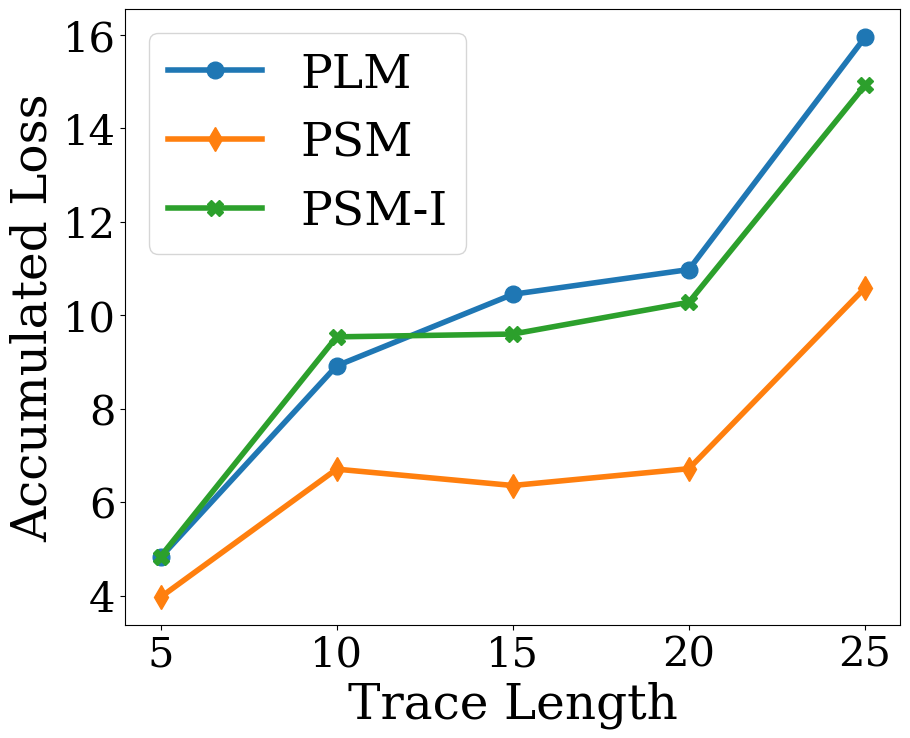

In [5]:
# ============================================================
# Trace length vs. accumulated loss (DROP-IN notebook version)
# - Uses your NEW PLM / NEW PSM / NEW PSM-I (no TR-PSM)
# - Removes unused imports + old samplers
# ============================================================

import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from noise_distribution import (
    sample_laplace_radius,
    sample_psm_radius,
    sample_psm_radius_bounded
)
from util import haversine_distance, initial_bearing, destination_point

# =============================================================================
# 1) MATPLOTLIB STYLING (same vibe, but simple)
# =============================================================================
mpl.rcParams['text.usetex']      = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family']      = 'serif'
mpl.rcParams['font.size']        = 30

# =============================================================================
# 2) CONSTANTS
# =============================================================================
EARTH_RADIUS        = 6_371_000  # meters
OVERLAY_RADIUS      = 100        # meters
POKEMON_MAX_RADIUS  = 1000       # meters
POKEMON_SPACING     = 100         # meters
DELTA_THRESHOLD     = 5.0        # base refresh threshold (PSM-I)
FIXED_CENTER        = (43.083789, -77.680391)

# =============================================================================
# 3) TRAJECTORY GENERATOR (synthetic)
# =============================================================================
def move_point(lat, lon, dist_m, bearing_deg, earth_radius=EARTH_RADIUS):
    φ1 = math.radians(lat)
    λ1 = math.radians(lon)
    θ  = math.radians(bearing_deg)
    δ  = dist_m / earth_radius
    φ2 = math.asin(math.sin(φ1)*math.cos(δ) +
                   math.cos(φ1)*math.sin(δ)*math.cos(θ))
    λ2 = λ1 + math.atan2(math.sin(θ)*math.sin(δ)*math.cos(φ1),
                         math.cos(δ)-math.sin(φ1)*math.sin(φ2))
    return math.degrees(φ2), math.degrees(λ2)

def generate_trajectory(start_lat, start_lon, step_distance_m, m):
    traj = [(start_lat, start_lon)]
    lat, lon = start_lat, start_lon
    for _ in range(m - 1):
        bearing = random.uniform(0, 360)
        lat, lon = move_point(lat, lon, step_distance_m, bearing)
        traj.append((lat, lon))
    return traj

# =============================================================================
# 4) POKÉMON POSITIONS
# =============================================================================
def generate_uniform_pokemon_positions(center, max_radius, spacing):
    lat0, lon0 = center
    deg_lat = 1/111320.0
    deg_lon = 1/(111320.0 * math.cos(math.radians(lat0)))
    positions = []

    lat = lat0 - max_radius * deg_lat
    while lat <= lat0 + max_radius * deg_lat:
        lon = lon0 - max_radius * deg_lon
        while lon <= lon0 + max_radius * deg_lon:
            if haversine_distance(lat0, lon0, lat, lon, EARTH_RADIUS) <= max_radius:
                positions.append((lat, lon))
            lon += spacing * deg_lon
        lat += spacing * deg_lat
    return positions

POKEMONS = generate_uniform_pokemon_positions(FIXED_CENTER, POKEMON_MAX_RADIUS, POKEMON_SPACING)

# =============================================================================
# 5) METRIC: catch% + accumulated loss
# =============================================================================
def compute_catch_and_loss(true_locs, pert_locs, overlay_radius=OVERLAY_RADIUS):
    total_true = total_intersect = acc_loss = 0
    for (lat_t, lon_t), (lat_p, lon_p) in zip(true_locs, pert_locs):
        V = [p for p in POKEMONS
             if haversine_distance(lat_t, lon_t, p[0], p[1], EARTH_RADIUS) <= overlay_radius]
        Vhat = [p for p in V
                if haversine_distance(lat_p, lon_p, p[0], p[1], EARTH_RADIUS) <= overlay_radius]
        total_true      += len(V)
        total_intersect += len(Vhat)
        acc_loss        += (len(V) - len(Vhat))

    catch_pct = (total_intersect/total_true)*100 if total_true else 0.0
    return catch_pct, acc_loss

# =============================================================================
# 6) NEW MECHANISMS (PLM / PSM / PSM-I)
# =============================================================================
def planar_laplace_mechanism(lat: float, lon: float, epsilon: float, earth_radius: float = EARTH_RADIUS):
    r = sample_laplace_radius(epsilon)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p

def planar_staircase_mechanism(lat: float, lon: float, epsilon: float, delta: float = 1.0, earth_radius: float = EARTH_RADIUS):
    r = sample_psm_radius(epsilon, delta=delta)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p

def bounded_planar_staircase_mechanism(lat, lon, epsilon, r_b, earth_radius: float = EARTH_RADIUS, delta_step: float = 1.0):
    r = sample_psm_radius_bounded(epsilon, L=r_b, delta=delta_step)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p

def apply_psmi_to_dataframe(
    df,
    epsilon,
    delta,
    r_b=50.0,
    thr_L=2.0,                    # bound for threshold-noise (your “good results”)
    earth_radius: float = EARTH_RADIUS,
    use_noisy_threshold=True
):
    n = len(df)
    y_lat = np.zeros(n)
    y_lon = np.zeros(n)
    z_lat = np.zeros(n)
    z_lon = np.zeros(n)

    # threshold sampled once per trajectory
    threshold = float(delta)
    if use_noisy_threshold:
        noise = sample_psm_radius_bounded(epsilon, L=thr_L, delta=delta)
        threshold = float(delta + noise)

    # init
    x1_lat, x1_lon = float(df.iloc[0]["latitude"]), float(df.iloc[0]["longitude"])
    y1_lat, y1_lon = bounded_planar_staircase_mechanism(
        x1_lat, x1_lon, epsilon, r_b,
        earth_radius=earth_radius,
        delta_step=delta
    )
    z1_lat, z1_lon = planar_staircase_mechanism(
        y1_lat, y1_lon, epsilon,
        delta=delta,
        earth_radius=earth_radius
    )

    y_lat[0], y_lon[0] = y1_lat, y1_lon
    z_lat[0], z_lon[0] = z1_lat, z1_lon

    y_ref_lat, y_ref_lon = y1_lat, y1_lon
    z_ref_lat, z_ref_lon = z1_lat, z1_lon

    for t in range(1, n):
        x_prev_lat, x_prev_lon = float(df.iloc[t-1]["latitude"]), float(df.iloc[t-1]["longitude"])
        x_cur_lat,  x_cur_lon  = float(df.iloc[t]["latitude"]),   float(df.iloc[t]["longitude"])

        d_h = float(haversine_distance(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon, earth_radius))
        theta = float(initial_bearing(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon))

        y_cur_lat, y_cur_lon = destination_point(y_lat[t-1], y_lon[t-1], d_h, theta, earth_radius)
        y_lat[t], y_lon[t] = y_cur_lat, y_cur_lon

        d_y = float(haversine_distance(y_ref_lat, y_ref_lon, y_cur_lat, y_cur_lon, earth_radius))
        if d_y < threshold:
            z_lat[t], z_lon[t] = z_ref_lat, z_ref_lon
        else:
            z_new_lat, z_new_lon = planar_staircase_mechanism(
                y_cur_lat, y_cur_lon, epsilon,
                delta=delta,
                earth_radius=earth_radius
            )
            z_lat[t], z_lon[t] = z_new_lat, z_new_lon
            y_ref_lat, y_ref_lon = y_cur_lat, y_cur_lon
            z_ref_lat, z_ref_lon = z_new_lat, z_new_lon

    return z_lat, z_lon

# =============================================================================
# 7) SIMULATION: accumulated loss vs trace length
# =============================================================================
def simulate_accumulated_loss(
    users_by_length,
    epsilon,
    delta,
    iterations=20,
    psm_delta=1.0,
    psmi_r_b=50.0,
    psmi_thr_L=2.0,
    use_noisy_threshold=True
):
    lengths = sorted(users_by_length.keys())
    losses = {L: {'PLM': 0.0, 'PSM': 0.0, 'PSM-I': 0.0} for L in lengths}

    for L in lengths:
        users = users_by_length[L]
        mech_user_loss = {'PLM': [], 'PSM': [], 'PSM-I': []}

        for traj in users:
            df_traj = pd.DataFrame(traj, columns=['latitude', 'longitude'])

            plm_losses = []
            psm_losses = []
            psmi_losses = []

            for _ in range(iterations):
                pert_l = [planar_laplace_mechanism(lat, lon, epsilon) for lat, lon in traj]
                _, loss_l = compute_catch_and_loss(traj, pert_l)
                plm_losses.append(loss_l)

                pert_s = [planar_staircase_mechanism(lat, lon, epsilon, delta=psm_delta) for lat, lon in traj]
                _, loss_s = compute_catch_and_loss(traj, pert_s)
                psm_losses.append(loss_s)

                z_lat, z_lon = apply_psmi_to_dataframe(
                    df_traj,
                    epsilon=epsilon,
                    delta=delta,
                    r_b=psmi_r_b,
                    thr_L=psmi_thr_L,
                    use_noisy_threshold=use_noisy_threshold
                )
                pert_i = list(zip(z_lat, z_lon))
                _, loss_i = compute_catch_and_loss(traj, pert_i)
                psmi_losses.append(loss_i)

            mech_user_loss['PLM'].append(float(np.mean(plm_losses)))
            mech_user_loss['PSM'].append(float(np.mean(psm_losses)))
            mech_user_loss['PSM-I'].append(float(np.mean(psmi_losses)))

        losses[L]['PLM']   = float(np.mean(mech_user_loss['PLM']))
        losses[L]['PSM']   = float(np.mean(mech_user_loss['PSM']))
        losses[L]['PSM-I'] = float(np.mean(mech_user_loss['PSM-I']))

    return losses

# =============================================================================
# 8) PLOT
# =============================================================================
def plot_loss_vs_length(data_dir, dataset_name, losses_by_length, epsilon):
    os.makedirs(data_dir, exist_ok=True)

    lengths = sorted(losses_by_length.keys())
    plt.figure(figsize=(10, 8))

    for mech, marker in [('PLM', 'o'), ('PSM', 'd'), ('PSM-I', 'X')]:
        vals = [losses_by_length[L][mech] for L in lengths]
        plt.plot(lengths, vals, label=mech, marker=marker, linewidth=4, markersize=12)

    plt.xlabel('Trace Length', fontsize=35)
    plt.ylabel('Accumulated Loss', fontsize=35)
    plt.xticks(lengths, fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=34, frameon=True, loc='upper left')

    fn = f"{dataset_name}_loss_eps{str(epsilon).replace('.','')}.pdf"
    plt.savefig(os.path.join(data_dir, fn), format='pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

# =============================================================================
# 9) USAGE EXAMPLE
# =============================================================================
random.seed(0)

trace_lengths   = [5, 10, 15, 20, 25]
step_distances  = [3, 4, 5, 6, 7]  # create 5 users per length

users_by_length = {
    L: [generate_trajectory(FIXED_CENTER[0], FIXED_CENTER[1], d, L) for d in step_distances]
    for L in trace_lengths
}

data_dir     = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\figures"
dataset_name = "pokemon_sparse_accumulated_loss"

epsilons   = [0.1]
iterations = 20

for eps in epsilons:
    losses = simulate_accumulated_loss(
        users_by_length,
        epsilon=eps,
        delta=DELTA_THRESHOLD,
        iterations=iterations,
        psm_delta=1.0,
        psmi_r_b=50.0,
        psmi_thr_L=2.0,
        use_noisy_threshold=True
    )
    plot_loss_vs_length(data_dir, dataset_name, losses, eps)
